In [1]:
import numpy as np
import pandas as pd
from mat4py import loadmat
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.utils import resample
from scipy import signal
import os
from scipy.linalg import circulant
import matplotlib.pyplot as plt
import random
import scipy

In [2]:
def csqi_calc(signal,signal_samplingrate,curve,curvefreq):
    #function to calculate curve matching sqi
    #signal - single channel signal
    #signal_samplingrate - sampling frequency of the signal
    #  curve - curve against which correlation of each heartbeat section
    #is compared.
    # curvefreq - sampling rate of the curve


    if np.sum(signal)==0:
        sqi=np.empty((1, signal.shape[1]))
        c_sqi=np.empty((1, signal.shape[1]))
    else:
        Fs=signal_samplingrate;
        if signal.shape[0]!=1:
            signal=signal.transpose()
            signal=np.reshape(signal, (1, -1))
    
        sqi=np.zeros((1, signal.shape[1]))
        c_sqi=np.zeros((1, signal.shape[1]))
        if Fs!=curvefreq:
            curve = scipy.signal.resample_poly(curve,Fs,curvefreq);
        window_size=len(curve);
        signal2=np.hstack((np.fliplr(np.reshape(signal[0,0:round(window_size/2)],(1,-1))),signal,np.fliplr(np.reshape(signal[0,(len(signal)-round(window_size/2)):signal.shape[1]],(1,-1)))));#mirroring signal towards the beginning and end

        k=0;
        x=curve.transpose()
        y=np.fliplr(x)
        y=np.hstack((y,np.zeros((1,window_size-1))))
        P=circulant(y[0,:])
        P=P.transpose()
        P=P[0:window_size,:]
        lag=np.arange(-(window_size-1),window_size)
    
    
        #window=np.hstack((np.reshape(signal2[0, max(0,k-round(window_size/2)+1):k],(1,-1)),np.reshape(signal2[:,k],(1,-1)),np.reshape(signal2[0, k+1:min(k+round(window_size/2)-1,signal2.shape[1])],(1,-1)))) #mirroring signal towards the beginning and end
        window=np.hstack((np.reshape(signal2[0, max(0,k-round(window_size/2)+1):k+1],(1,-1)),np.reshape(signal2[:,k],(1,-1)),np.reshape(signal2[0, k+1:min(k+round(window_size/2)-1,signal2.shape[1])],(1,-1)))) #mirroring signal towards the beginning and end
    
        if (k-round(window_size/2))<0:
            window=np.hstack((np.zeros((1,round(window_size/2)-k)),window))
    
    
        if (k+round(window_size/2))>signal2.shape[1]:
            window=np.hstack((window, np.zeros((1,(window_size-window.shape[1])))))
    
        window1=np.diag(window[0,:]);
        tot=np.matmul(window1,P)
        total=np.sum(tot,axis=0);
        total1=np.fliplr(np.reshape(total,(1,-1)))
        total1=total1[0,:]
        I=np.argmax(total1)
        
        beg_last=window[0,0]
        correction=lag[I]
        corrected_curve=np.roll(curve.transpose()[0,:],-correction)
        diff=np.var(corrected_curve-window)
        c_sqi[0,k]=diff;
        
        if c_sqi[0,k]!=0:
            sqi[0,k]=1/c_sqi[0,k]
        else:
            sqi[0,k]=0.014;
    
        if sqi[0,k]<0: #limiting negative SQI values to 0.0001
            sqi[0,k]=0
            
        
    
    


        for k in range(1,signal2.shape[1]):
            window=window[:,1:]
        
        
            if (round(window_size/2)+k-1>signal2.shape[1]):
                window=np.hstack((window, np.zeros((1,(window_size-window.shape[1])))))
            else:
                window=np.hstack((window,np.reshape(signal2[:,round(window_size/2)+k-2],(1,-1))))
            
        
            last_term=window[0,-1];
            new_row=last_term*P[-1,:];
            first_row=beg_last*P[0,:];
            total=total-first_row;
            total=np.roll(total,-1);
            total=total+new_row;
            beg_last=window[0,0];
            total1=np.fliplr(np.reshape(total,(1,-1)));
            total1=total1[0,:]
            I=np.argmax(total1)
            correction=lag[I];
            corrected_curve=np.roll(curve.transpose()[0,:],-correction);
            diff=np.var(corrected_curve-window)
            
            if k>=signal.shape[1]:
                
                c_sqi=np.hstack((c_sqi,np.reshape(diff,(1,-1))))
                if c_sqi[0,k]!=0:
                    sqi=np.hstack((sqi,np.reshape(1/c_sqi[0,k],(1,-1))))
                else:
                    sqi=np.hstack((sqi,np.reshape(0.014,(1,-1))))
            else:
                c_sqi[0,k]=diff
                if c_sqi[0,k]!=0:
                    sqi[0,k]=1/c_sqi[0,k]
                else:
                    sqi[0,k]=0.014;
    
            if sqi[0,k]<0: #limiting negative SQI values to 0.0001
                sqi[0,k]=0
        

        sqi=sqi[:,round((sqi.shape[1]-signal.shape[1])/2)+1:round((sqi.shape[1]+signal.shape[1])/2)+1];
    return sqi



In [3]:
valid_features1=np.zeros((1, 2500))
valid_features2=np.zeros((1, 2500))
test_features1=np.zeros((1, 2500))
test_features2=np.zeros((1, 2500))

true_folder='D:\PhD topics\Datasets\Afib_datasets\selected_dataset\Afib\selected_signals\split'
file_list=os.listdir(true_folder)

for i in file_list:
    if i.endswith(".mat") & ("ecg" in i) & ("valid" in i):
        record = loadmat(true_folder+'\\'+i)
        ecg_valid = np.array(record['ecg_valid'])
        valid_features1=np.append(valid_features1,ecg_valid,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("valid" in i):
        record = loadmat(true_folder+'\\'+i)
        spo2_valid = np.array(record['spo2_valid'])
        valid_features2=np.append(valid_features2,spo2_valid,axis=0)
        
    if i.endswith(".mat") & ("ecg" in i) & ("test" in i):
        record = loadmat(true_folder+'\\'+i)
        ecg_test = np.array(record['ecg_test'])
        test_features1=np.append(test_features1,ecg_test,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("test" in i):
        record = loadmat(true_folder+'\\'+i)
        spo2_test = np.array(record['spo2_test'])
        test_features2=np.append(test_features2,spo2_test,axis=0)
        


ecg_valid_true=valid_features1[1:]
spo2_valid_true=valid_features2[1:]
ecg_test_true=test_features1[1:]
spo2_test_true=test_features2[1:]
labels_valid_true=np.ones((len(ecg_valid_true),1))
labels_test_true=np.ones((len(ecg_test_true),1))

In [4]:
valid_features1=np.zeros((1, 2500))
valid_features2=np.zeros((1, 2500))
test_features1=np.zeros((1, 2500))
test_features2=np.zeros((1, 2500))

false_folder="D:\\PhD topics\\Datasets\\Afib_datasets\\selected_dataset\\Normal\\selected_signals\\split"
file_list=os.listdir(false_folder)

for i in file_list:
    if i.endswith(".mat") & ("ecg" in i) & ("valid" in i):
        record = loadmat(false_folder+'\\'+i)
        ecg_valid = np.array(record['ecg_valid'])
        if len(ecg_valid)!=0:
            valid_features1=np.append(valid_features1,ecg_valid,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("valid" in i):
        record = loadmat(false_folder+'\\'+i)
        spo2_valid = np.array(record['spo2_valid'])
        if len(spo2_valid)!=0:
            valid_features2=np.append(valid_features2,spo2_valid,axis=0)
        
    if i.endswith(".mat") & ("ecg" in i) & ("test" in i):
        record = loadmat(false_folder+'\\'+i)
        ecg_test = np.array(record['ecg_test'])
        if len(ecg_test)!=0:
            test_features1=np.append(test_features1,ecg_test,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("test" in i):
        record = loadmat(false_folder+'\\'+i)
        spo2_test = np.array(record['spo2_test'])
        if len(spo2_test)!=0:
            test_features2=np.append(test_features2,spo2_test,axis=0)
        


ecg_valid_false=valid_features1[1:]
spo2_valid_false=valid_features2[1:]
ecg_test_false=test_features1[1:]
spo2_test_false=test_features2[1:]
labels_valid_false=np.zeros((len(ecg_valid_false),1))
labels_test_false=np.zeros((len(ecg_test_false),1))

In [5]:
train_features1=np.zeros((1, 2500))
train_features2=np.zeros((1, 2500))


true_folder='D:\PhD topics\Datasets\Afib_datasets\selected_dataset\Afib\selected_signals\split'
file_list=os.listdir(true_folder)

for i in file_list:
    if i.endswith(".mat") & ("ecg" in i) & ("train" in i):
        record = loadmat(true_folder+'\\'+i)
        ecg_train = np.array(record['ecg_train'])
        if len(ecg_train)!=0:
            train_features1=np.append(train_features1,ecg_train,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("train" in i):
        record = loadmat(true_folder+'\\'+i)
        spo2_train = np.array(record['spo2_train'])
        if len(spo2_train)!=0:
            train_features2=np.append(train_features2,spo2_train,axis=0)
        
ecg_train_true=train_features1[1:]
spo2_train_true=train_features2[1:]
labels_train_true=np.ones((len(ecg_train_true),1))

In [6]:
train_features1=np.zeros((1, 2500))
train_features2=np.zeros((1, 2500))


false_folder='D:\\PhD topics\\Datasets\\Afib_datasets\\selected_dataset\\Normal\\selected_signals\\split'
file_list=os.listdir(false_folder)

for i in file_list:
    if i.endswith(".mat") & ("ecg" in i) & ("train" in i):
        record = loadmat(false_folder+'\\'+i)
        ecg_train = np.array(record['ecg_train'])
        if len(ecg_train)!=0:
            train_features1=np.append(train_features1,ecg_train,axis=0)
    
    if i.endswith(".mat") & ("spo2" in i) & ("train" in i):
        record = loadmat(false_folder+'\\'+i)
        spo2_train = np.array(record['spo2_train'])
        if len(spo2_train)!=0:
            train_features2=np.append(train_features2,spo2_train,axis=0)
        
ecg_train_false=train_features1[1:]
spo2_train_false=train_features2[1:]
labels_train_false=np.zeros((len(ecg_train_false),1))

In [7]:
features_train_true=np.append(ecg_train_true,spo2_train_true, axis=1) 
features_train_false=np.append(ecg_train_false,spo2_train_false, axis=1)
X_train=np.append(features_train_true,features_train_false, axis=0)
y_train=np.append(labels_train_true, labels_train_false, axis=0)

In [8]:
features_valid_true=np.append(ecg_valid_true,spo2_valid_true, axis=1) 
features_valid_false=np.append(ecg_valid_false,spo2_valid_false, axis=1)
X_valid=np.append(features_valid_true,features_valid_false, axis=0)
y_valid=np.append(labels_valid_true, labels_valid_false, axis=0)

In [9]:
features_test_true=np.append(ecg_test_true,spo2_test_true, axis=1) 
features_test_false=np.append(ecg_test_false,spo2_test_false, axis=1)
X_test=np.append(features_test_true,features_test_false, axis=0)
y_test=np.append(labels_test_true, labels_test_false, axis=0)

In [10]:
ecg_train_true

array([[ 0.08503848,  0.0841321 ,  0.08277254, ...,  0.0592067 ,
         0.06056627,  0.06192584],
       [ 0.06645773,  0.06645773,  0.06645773, ...,  0.07280238,
         0.07144281,  0.06963005],
       [ 0.07053643,  0.07098962,  0.07053643, ...,  0.06328541,
         0.06464497,  0.06509816],
       ...,
       [ 0.07733586,  0.10131326,  0.12529067, ..., -0.04734665,
        -0.02336924,  0.00780138],
       [-0.28712069, -0.17922237, -0.11688112, ...,  0.26435961,
         0.83022636,  0.89976083],
       [-0.24875685, -0.51970152, -0.56765633, ...,  0.05335845,
         0.03897201, -0.03775569]])

In [11]:
def scale_mul(signals,mul,diff):
    
    signal_copy=signals.copy()
    return signal_copy*mul

def shift_add(signals,addi,diff):
    
    signal_copy=signals.copy()
    return signal_copy+addi

def add_noise_white(signals_copy):
    SNR_dB=-20
    
    for i in range(len(signals_copy)):
        squares=np.linalg.norm(signals_copy[i,:],2)**2
        variance=squares/(10**(SNR_dB/10))
        k=(variance - 0) * np.random.random_sample(1) 
        nois=np.random.normal(size=len(signals_copy[i,:]))
        nois=(nois-np.mean(nois))/np.linalg.norm(nois,2)
        signals_copy[i,:]=signals_copy[i,:]+np.sqrt(k)*nois
    return signals_copy

class augment_class_simult:
    
    
                
                
        
    def add_gaus(self, signals_copy):
        if self.both:
            aug=signals_copy
            aug_signal_1=signals_copy[:,0:round((signals_copy.shape[1])/2)]
            aug_signal_2=signals_copy[:,round((signals_copy.shape[1])/2):signals_copy.shape[1]]
            aug_signal_1=add_noise_white(aug_signal_1)
            aug_signal_2=add_noise_white(aug_signal_2)
            aug[:,0:round((signals_copy.shape[1])/2)]=aug_signal_1
            aug[:,round((signals_copy.shape[1])/2):signals_copy.shape[1]]=aug_signal_2
            
            
        else:
            
            aug_signals=signals_copy
            aug=add_noise_white(aug_signals)
        return aug
    
    
    
    def addnoise(self,signals, label, diff):
        self.label=label
        if diff>signals.shape[0]:
            rem=signals.shape[0]
            signals=np.append(signals,signals, axis=0)
            rec=random.sample(range(signals.shape[0]), abs(diff-rem))
            signals_add=signals[rec,:]
                
        else:
            rec=random.sample(range(signals.shape[0]), diff)   
            signals_add=signals[rec,:]
                
        signals=np.append(signals,signals_add, axis=0) 
            
        self.signals=signals
        self.label=label
        rec=random.sample(range(signals.shape[0]), signals.shape[0]) 
        add_ecg=rec[0:round(0.25*signals.shape[0])]
        add_ppg=rec[round(0.25*signals.shape[0]): round(0.5*signals.shape[0])]
        add_both= rec[round(0.5*signals.shape[0]): round(0.75*signals.shape[0])]
        
        self.both=False
        aug_sig= self.add_gaus(self.signals[add_ecg,0:round((self.signals.shape[1])/2)])
        self.signals[add_ecg,0:round((self.signals.shape[1])/2)] = aug_sig
        
        aug_sig= self.add_gaus(self.signals[add_ppg,round((self.signals.shape[1])/2):self.signals.shape[1]])
        self.signals[add_ppg,round((self.signals.shape[1])/2):self.signals.shape[1]] = aug_sig
        
        self.both=True
        aug_sig= self.add_gaus(self.signals[add_both,])
        self.signals[add_both,] = aug_sig
        
        self.both=False
            
            
        if self.label==0:
            labels=np.zeros((self.signals.shape[0]))
        if self.label==1:
            labels=np.ones((self.signals.shape[0]))
        return self.signals, labels

In [12]:
aug_class=augment_class_simult()

In [13]:
features_train_true_aug, labels_true_train=aug_class.addnoise(features_train_true,1, abs(features_train_true.shape[0]-features_train_false.shape[0]))

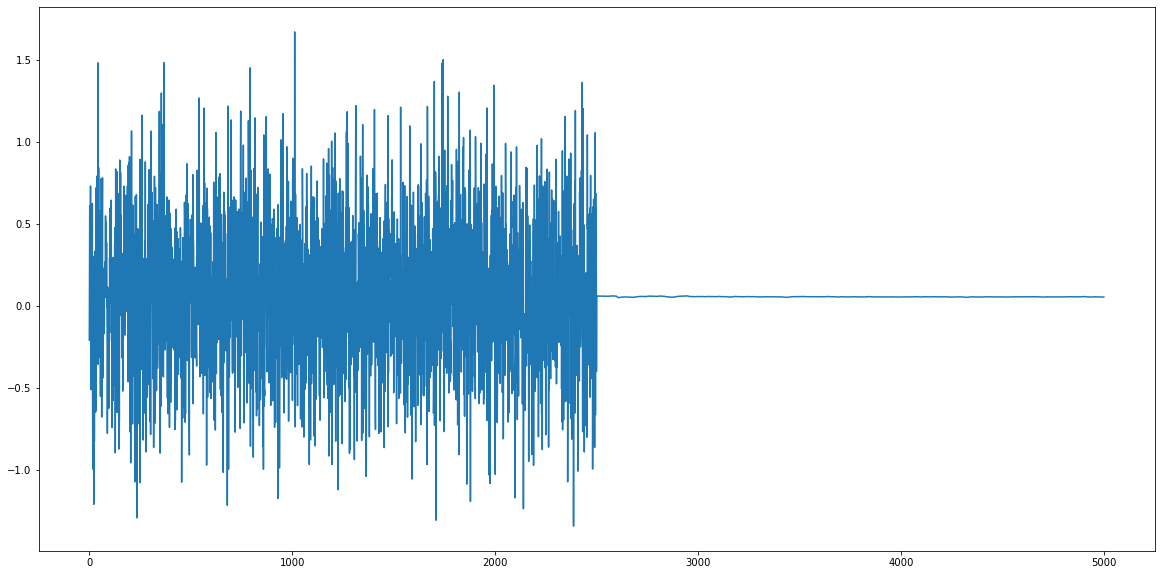

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(features_train_true_aug[789,:])

In [15]:
features_train_false_aug, labels_false_train=aug_class.addnoise(features_train_false,0, 0)

In [16]:
X_train=np.append(features_train_true_aug,features_train_false_aug, axis=0) 
y_train=np.append(labels_true_train,labels_false_train,axis=0)

In [17]:
features_valid_true_aug, labels_true_valid=aug_class.addnoise(features_valid_true,1, abs(features_valid_true.shape[0]-features_valid_false.shape[0]))
features_valid_false_aug, labels_false_valid=aug_class.addnoise(features_valid_false,0, 0)

X_valid=np.append(features_valid_true_aug,features_valid_false_aug, axis=0) 
y_valid=np.append(labels_true_valid,labels_false_valid,axis=0)

In [18]:
features_test_true_aug, labels_true_test=aug_class.addnoise(features_test_true,1, 0)
features_test_false_aug, labels_false_test=aug_class.addnoise(features_test_false,0, 0)


X_test=np.append(features_test_true_aug,features_test_false_aug, axis=0) 
y_test=np.append(labels_true_test,labels_false_test,axis=0)

In [19]:
ecg_train=X_train[:,0:round(X_train.shape[1]/2)]
ppg_train=X_train[:,round(X_train.shape[1]/2):X_train.shape[1]]

ecg_valid=X_valid[:,0:round(X_valid.shape[1]/2)]
ppg_valid=X_valid[:,round(X_valid.shape[1]/2):X_valid.shape[1]]

ecg_test=X_test[:,0:round(X_test.shape[1]/2)]
ppg_test=X_test[:,round(X_test.shape[1]/2):X_test.shape[1]]

In [20]:
overall_mean=np.nanmean(ecg_train)
ecg_train[np.isnan(ecg_train)]=overall_mean
ecg_valid[np.isnan(ecg_valid)]=overall_mean
ecg_test[np.isnan(ecg_test)]=overall_mean


ecg_train_mean=np.nanmean(ecg_train, axis=0)
ecg_train_std=np.nanstd(ecg_train, axis=0)

for i in range(ecg_train.shape[0]):
    ecg_train[i,:]=(ecg_train[i,:]-ecg_train_mean)/ecg_train_std
    
for i in range(ecg_valid.shape[0]):
    ecg_valid[i,:]=(ecg_valid[i,:]-ecg_train_mean)/ecg_train_std
    
for i in range(ecg_test.shape[0]):
    ecg_test[i,:]=(ecg_test[i,:]-ecg_train_mean)/ecg_train_std

In [21]:
ppg_test

array([[ 0.45358528,  0.1565292 , -0.01524796, ..., -0.5757209 ,
        -0.05410589,  0.00796164],
       [ 0.05570021,  0.05570021,  0.0551619 , ...,  0.05946842,
         0.05946842,  0.05946842],
       [-0.20405583,  0.13428271,  0.48177133, ...,  0.17207052,
        -0.02573702, -0.12836381],
       ...,
       [-0.27934129, -0.29917745, -0.31534025, ..., -0.80316283,
        -0.80610152, -0.8119789 ],
       [ 0.04538398,  0.13427936,  0.22758278, ..., -0.60700526,
        -0.62243338, -0.63712683],
       [ 7.46263956, -7.08538793, -5.57498295, ...,  2.7486915 ,
        -1.11628461,  2.82382157]])

In [22]:
ppg_train_mean=np.mean(ppg_train)
ppg_train_std=np.std(ppg_train)

for i in range(ppg_train.shape[0]):
    ppg_train[i,:]=(ppg_train[i,:]-ppg_train_mean)/ppg_train_std
    
for i in range(ppg_valid.shape[0]):
    ppg_valid[i,:]=(ppg_valid[i,:]-ppg_train_mean)/ppg_train_std
    
for i in range(ppg_test.shape[0]):
    ppg_test[i,:]=(ppg_test[i,:]-ppg_train_mean)/ppg_train_std

In [23]:
ECG = loadmat('D:\\PhD topics\\Datasets\\training\\training\\ecg_template.mat')
ECG=ECG['ECG']
ecgcurve=np.array(ECG['curve'])
curvefreq=ECG['Fs']


ecg_sqi_train=np.zeros((ecg_train.shape))
for i in range(len(ecg_train)):
    ecg_sqi_train[i,:]=csqi_calc(ecg_train[i,:],125,ecgcurve,curvefreq)

In [24]:
ecg_sqi_valid=np.zeros((ecg_valid.shape))
for i in range(len(ecg_valid)):
    ecg_sqi_valid[i,:]=csqi_calc(ecg_valid[i,:],125,ecgcurve,curvefreq)

In [25]:
ecg_sqi_test=np.zeros((ecg_test.shape))
for i in range(len(ecg_test)):
    ecg_sqi_test[i,:]=csqi_calc(ecg_test[i,:],125,ecgcurve,curvefreq)

In [26]:
PPG = loadmat('D:\\PhD topics\\Datasets\\training\\training\\ppg_template.mat')
PPG=PPG['PPG']
ppgcurve=np.array(PPG['curve'])
curvefreq=PPG['Fs']

ppg_sqi_train=np.zeros((ppg_train.shape))
for i in range(len(ppg_train)):
    ppg_sqi_train[i,:]=csqi_calc(ppg_train[i,:],125,ppgcurve,curvefreq)
    
    
ppg_sqi_valid=np.zeros((ppg_valid.shape))
for i in range(len(ppg_valid)):
    ppg_sqi_valid[i,:]=csqi_calc(ppg_valid[i,:],125,ppgcurve,curvefreq)
    

In [27]:
ppg_sqi_test=np.zeros((ppg_test.shape))
for i in range(len(ppg_test)):
    ppg_sqi_test[i,:]=csqi_calc(ppg_test[i,:],125,ppgcurve,curvefreq)

In [29]:
import pickle

In [30]:
input_dictionary = {'ecg_train': ecg_train, 'ppg_train': ppg_train, 'ecg_valid': ecg_valid,
                    'ppg_valid': ppg_valid, 'ecg_test': ecg_test,
                    'ppg_test': ppg_test, 'y_train': y_train, 'y_valid': y_valid, 'y_test': y_test, 'ecg_sqi_train':ecg_sqi_train,
                   'ppg_sqi_train':ppg_sqi_train, 'ecg_sqi_valid':ecg_sqi_valid,'ppg_sqi_valid':ppg_sqi_valid, 
                    'ecg_sqi_test':ecg_sqi_test,'ppg_sqi_test':ppg_sqi_test }
            
file = open('D:\PhD topics\Datasets\Afib_datasets\store_noise_one_mean_final2_-20.pkl', 'wb')
pickle.dump(input_dictionary, file, protocol=4)
file.close()